In [16]:
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import process_time

tf.disable_v2_behavior()

In [21]:
# Read inputs (x) and corresponding outputs (y) for train set
df_x_train = pd.read_csv("newtrain.csv")
x_train = df_x_train.values

df_y_train = pd.read_csv("trainlabel.csv", header=None)
y_train = df_y_train.values

# Read inputs (x) and corresponding outputs (y) for test set
df_x_test = pd.read_csv("newtest.csv")
x_test = df_x_test.values

df_y_test = pd.read_csv("testlabel.csv", header=None)
y_test = df_y_test.values


(60000, 392)
(60000, 1)


In [22]:

# Remove classes 6, 2, and 3

indices = []

for i in range(y_train.shape[0]):
    if y_train[i, 0] == 6 or y_train[i, 0] == 2 or y_train[i, 0] == 3:
        indices.append(i)
    
y_train = np.delete(y_train, indices, 0)
x_train = np.delete(x_train, indices, 0)

indices = []

for i in range(y_test.shape[0]):
    if y_test[i, 0] == 6 or y_test[i, 0] == 2 or y_test[i, 0] == 3:
        indices.append(i)
        
y_test = np.delete(y_test, indices, 0)
x_test = np.delete(x_test, indices, 0)

# Make the class numbers 0, 1, 2 instead of 1, 4, 5
for i in range(y_train.shape[0]):
    if y_train[i, 0] == 1:
        y_train[i, 0] = 0
    
    elif y_train[i, 0] == 4:
        y_train[i, 0] = 1
    
    else:
        y_train[i, 0] = 2
        
for i in range(y_test.shape[0]):
    if y_test[i, 0] == 1:
        y_test[i, 0] = 0
    
    elif y_test[i, 0] == 4:
        y_test[i, 0] = 1
    
    else:
        y_test[i, 0] = 2


In [23]:
# Clean data to remove negative values

min_val = np.min(x_train)
if min_val < 0:
    x_train -= min_val
            
min_val = np.min(x_test)
if min_val < 0:
    x_test -= min_val

In [24]:
# Set up dimensions of layers

num_features = x_train.shape[1]
num_examples = x_train.shape[0]
# 34, 167
num_hid1 = 167 # Change to PCA values
num_output = len(set(y_train.flatten())) # number of unique y values (equals 3 after removing classes)
print(num_output)

norm_sum = 0
for row in x_train:
    norm_sum += np.linalg.norm(row)
    
avg_norm = norm_sum / num_examples
print(avg_norm)

3
3.4339969874970473


In [25]:
actf = tf.nn.relu # Define response function

X = tf.placeholder(tf.float32, shape=[None, num_features], name="X") #input vector/layer
Y = tf.placeholder(tf.int32, shape=[None, 1], name="Y") # Corresponding known output 

initializer = tf.variance_scaling_initializer() #initializer for initializing weights (Guassian random)

# Weights
W1 = tf.Variable(initializer([num_features, num_hid1]), dtype=tf.float32)
W2 = tf.Variable(initializer([num_hid1, num_output]), dtype=tf.float32)

# thresholds
b1 = tf.Variable(tf.zeros(num_hid1))
b2 = tf.Variable(tf.zeros(num_output))

# Define model of the graph
hid_layer = actf(tf.matmul(X, W1) + b1)  # compute hidden layer
output = actf(tf.matmul(hid_layer, W2) + b2)  # compute outer layer

# Softmax layer 
softmax_output = tf.nn.softmax(output)

# Decision using arg max
decision = tf.math.argmax(softmax_output, axis=1)

# One hot encoding of known output Y, ie 0 -> [1 0 0], 1 -> [0 1 0], etc
Y_one_hot = tf.one_hot(tf.reshape(Y, [tf.size(Y)]), 3)

# Cross Entropy loss function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=Y_one_hot))
#cost = tf.losses.mean_squared_error(softmax_output, Y_one_hot)

# Define learning rate and gradient descent optimizer
global_step = tf.Variable(0, trainable=False) # Variable for keeping track of iteration number (used to decay learning rate)

starter_learning_rate = .0025
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.96) # Learning rate decay rate
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

# Gradients of cost function wrt weights
grads_and_vars = optimizer.compute_gradients(cost, var_list=[W1, W2, b1, b2])

# Training operation. This iterates gradient descent using learning rate given by current step
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

# Compute norm squared of gradients
grad_norms = [tf.pow(tf.norm(g), 2) for g,v in grads_and_vars] 

# Compute gradient of vector W containing all weights and thresholds
grad_norm = tf.sqrt(tf.add_n(grad_norms))

# Compute the confusion matrix
confusion_matrix = tf.confusion_matrix(Y, decision)

# Compute the accuracy
acc, acc_op = tf.metrics.accuracy(Y, decision)

init = tf.global_variables_initializer() # initialize variables
init_l = tf.local_variables_initializer() # ? Makes the accuracy work

In [31]:
# Set up training hyperparameters
num_epochs = 100
batch_size = 512

num_batches = num_examples // batch_size
total_steps = num_epochs * num_batches

In [32]:
# Run the training

# Start clock
start = process_time()

sess = tf.InteractiveSession()

sess.run(init) # Initialize the variables
sess.run(init_l)

cost_vector = np.zeros((total_steps,)) # Set up vector to store cost over time on training set (batch)
cost_vector_whole_x_train = np.zeros((num_epochs,)) # Set up vector to store cost over time on entire training set
test_cost_vector = np.zeros((num_epochs,)) # Set up vector to store MSE over time on test set
norm_diff_vec = np.zeros((total_steps,)) # Set up vector to store norm(W(n) - W(n+1))
grad_norm_vec = np.zeros((total_steps,)) # Set up vector to store norm(grad) over time
train_accuracy_vec = np.zeros((num_epochs,)) # Set up vector to store accuracy on train set
test_accuracy_vec = np.zeros((num_epochs,)) # Set up vector to store accuracy on test set

current_iteration = 0 # Keeps track of total iterations passed

for epoch in range(num_epochs):

    # Shuffle rows of the training set at start of each epoch
    concat = np.concatenate((x_train, y_train), axis=1)
    np.random.shuffle(concat) 
    
    x_train = concat[:, 0:num_features]
    y_train = concat[:, num_features].reshape((num_examples, 1))

    for i in range(num_batches):

        # index of the beginning of batch i
        index = i * batch_size

        # Compute cost and norm of the gradient on the current batch
        train_dictionary = {X : x_train[index:index+batch_size, :], Y : y_train[index:index+batch_size, :]}
        loss, gradient_norm = sess.run([cost, grad_norm], feed_dict = train_dictionary)

        cost_vector[current_iteration] = loss # Store loss at time t

        # Obtain current values of weights and thresholds
        weight1, weight2, thresh1, thresh2 = sess.run([W1, W2, b1, b2], feed_dict = train_dictionary)
        norm_W = np.sqrt(np.linalg.norm(weight1) ** 2 + np.linalg.norm(weight2) ** 2 + np.linalg.norm(thresh1) ** 2 + np.linalg.norm(thresh2) ** 2)
        
        D = np.size(weight1) + np.size(weight2) + np.size(thresh1) + np.size(thresh2)
        grad_norm_vec[current_iteration] = gradient_norm / np.sqrt(D) # Store gradient norm at time t
        
        #iterate gradient descent
        sess.run(train_op, feed_dict = train_dictionary)

        # Calculate W(n) - W(n+1)
        new_weight1, new_weight2, new_thresh1, new_thresh2 = sess.run([W1, W2, b1, b2], feed_dict = train_dictionary)
        diff_weight1 = weight1 - new_weight1
        diff_weight2 = weight2 - new_weight2
        diff_thresh1 = thresh1 - new_thresh1
        diff_thresh2 = thresh2 - new_thresh2

        # Calculate and store norm(W(n) - W(n+1))
        norm_diff = np.sqrt(np.linalg.norm(diff_weight1) ** 2 + np.linalg.norm(diff_weight2) ** 2 + np.linalg.norm(diff_thresh1) ** 2 + np.linalg.norm(diff_thresh2) ** 2)
        norm_diff_vec[current_iteration] = norm_diff / norm_W

        current_iteration += 1

    # Calculate and store loss on entire test set and on entire training set
    test_loss = sess.run(cost, feed_dict = {X : x_test, Y : y_test})
    test_cost_vector[epoch] = test_loss
    cost_vector_whole_x_train[epoch] = sess.run(cost, feed_dict = {X : x_train, Y : y_train})
    
    train_accuracy_vec[epoch] = sess.run(acc_op, feed_dict={X : x_train, Y : y_train})
    test_accuracy_vec[epoch] = sess.run(acc_op, feed_dict={X : x_test, Y: y_test})

    # Print cost at end of each epoch    
    print("epoch {}: cost = {}".format(epoch, cost_vector[(epoch * num_batches) + num_batches -1]))
    
# End clock
end = process_time()
training_time = end - start

# Print final error on test set
print("End error on the training set: {}".format(cost_vector_whole_x_train[-1]))
print("End error on test set: {}".format(test_cost_vector[-1]))

print("Total training time: {}".format(training_time))



C:\Users\mattd\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch 0: cost = 0.977884829044342
epoch 1: cost = 0.8884381055831909
epoch 2: cost = 0.7964169979095459
epoch 3: cost = 0.7456874251365662
epoch 4: cost = 0.6992286443710327
epoch 5: cost = 0.6122207641601562
epoch 6: cost = 0.5908536314964294
epoch 7: cost = 0.5197770595550537
epoch 8: cost = 0.5494140982627869
epoch 9: cost = 0.5065039992332458
epoch 10: cost = 0.44936829805374146
epoch 11: cost = 0.43844330310821533
epoch 12: cost = 0.40465372800827026
epoch 13: cost = 0.389460027217865
epoch 14: cost = 0.3876170217990875
epoch 15: cost = 0.34070366621017456
epoch 16: cost = 0.33197373151779175
epoch 17: cost = 0.2932998538017273
epoch 18: cost = 0.293857604265213
epoch 19: cost = 0.25857454538345337
epoch 20: cost = 0.2535051703453064
epoch 21: cost = 0.23086459934711456
epoch 22: cost = 0.2157599925994873
epoch 23: cost = 0.21657907962799072
epoch 24: cost = 0.23724359273910522
epoch 25: cost = 0.1861678957939148
epoch 26: cost = 0.20581863820552826
epoch 27: cost = 0.200783431529

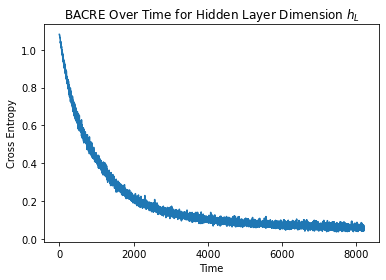

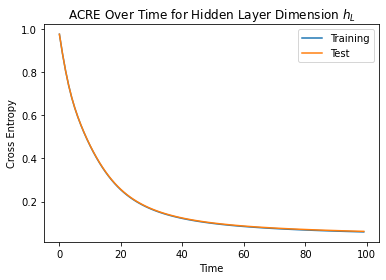

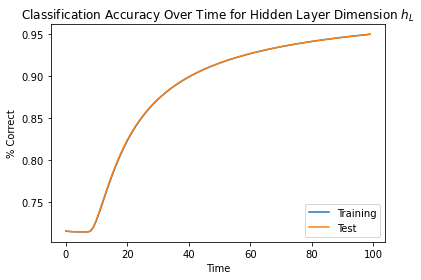

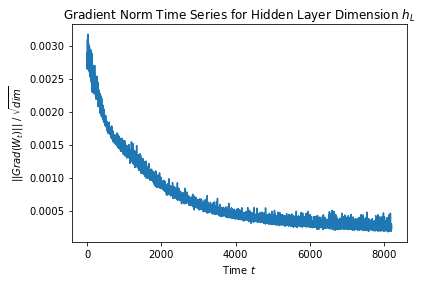

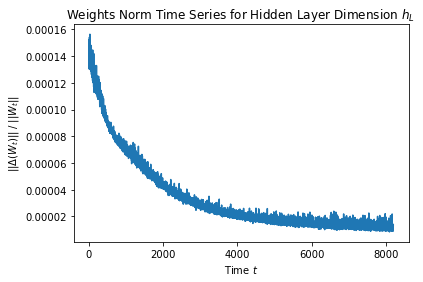

In [35]:
# Plot the data from training

x = range(total_steps)
epochs = range(num_epochs)

# Plot Cost over time on batch training
plt.plot(x, cost_vector)
plt.title("BACRE Over Time for Hidden Layer Dimension $h_{L}$")
plt.xlabel("Time")
plt.ylabel("Cross Entropy")
plt.show()

# Plot cost over time on whole training set and test set
plt.plot(epochs, cost_vector_whole_x_train, label="Training")
plt.plot(epochs, test_cost_vector, label="Test")
plt.title("ACRE Over Time for Hidden Layer Dimension $h_{L}$")
plt.xlabel("Time")
plt.ylabel("Cross Entropy")
plt.legend(loc="upper right")
plt.show()

# Plot accuracy over time on training and test set
plt.plot(epochs, train_accuracy_vec, label="Training")
plt.plot(epochs, test_accuracy_vec, label="Test")
plt.title("Classification Accuracy Over Time for Hidden Layer Dimension $h_{L}$")
plt.xlabel("Time")
plt.ylabel("% Correct")
plt.legend(loc="lower right")
plt.show()


# Plot norm(grad) over time
plt.plot(x, grad_norm_vec)
plt.title("Gradient Norm Time Series for Hidden Layer Dimension $h_L$ ")
plt.xlabel("Time $t$")
plt.ylabel("$\||Grad(W_t)\||\;/\;\sqrt{dim}}$")
plt.show()

# Plot norm(W(n) - W(n+1))/ norm(W(n)) over time
plt.plot(x, norm_diff_vec)
plt.title("Weights Norm Time Series for Hidden Layer Dimension $h_L$ ")
plt.xlabel("Time $t$")
plt.ylabel("$\||\Delta(W_t)\||\; / \;\||W_t\||$")
plt.show()

In [36]:
# Test performance
print("Final accuracy on training set: {}".format(train_accuracy_vec[-1]))
print("Final accuracy on test set: {}".format(test_accuracy_vec[-1]))

train_conf_matrix = sess.run(confusion_matrix, feed_dict={X : x_train, Y : y_train})
print("Training confusion matrix:")
print(train_conf_matrix)

test_conf_matrix = sess.run(confusion_matrix, feed_dict={X : x_test, Y : y_test})
print("Test confusion matrix:")
print(test_conf_matrix)

Final accuracy on training set: 0.9493196606636047
Final accuracy on test set: 0.9493726491928101
Training confusion matrix:
[[ 5812   102    86]
 [   73  5769   158]
 [   33   133 29834]]
Test confusion matrix:
[[ 968   17   15]
 [   6  970   24]
 [   5   28 4967]]


In [39]:
# Analysis for part 6
h_layer = sess.run(hid_layer, feed_dict={X : x_train})
#np.savetxt("hidden_layer.csv", h_layer, delimiter=",") # Save hidden layer as csv for PCA analysis in Matlab

H_bar = np.average(h_layer, axis=0)


# Split training set into 3 sets for each class
class_0_list = []
class_1_list = []
class_2_list = []

for i in range(x_train.shape[0]):
    if y_train[i, 0] == 0:
        class_0_list.append(x_train[i])
    
    elif y_train[i, 0] == 1:
        class_1_list.append(x_train[i])
    
    else:
        class_2_list.append(x_train[i])

class_0 = np.asarray(class_0_list)
class_1 = np.asarray(class_1_list)
class_2 = np.asarray(class_2_list)

# Get values in hidden layer for each class
H0 = sess.run(hid_layer, feed_dict={X : class_0})
H1 = sess.run(hid_layer, feed_dict={X : class_1})
H2 = sess.run(hid_layer, feed_dict={X : class_2})

# Find average value for each neuron in hidden layer for each class
H0_bar = np.average(H0, axis=0)
H1_bar = np.average(H1, axis=0)
H2_bar = np.average(H2, axis=0)

# Create binary vectors for each class. If neuron has higher activation in the class than the average => neuron gets value 1, else => gets 0  
H0_binary = np.zeros((H_bar.size,))
H1_binary = np.zeros((H_bar.size,))
H2_binary = np.zeros((H_bar.size,))

for i in range(H_bar.size):
    if H0_bar[i] > H_bar[i]:
        H0_binary[i] = 1
    
    if H1_bar[i] > H_bar[i]:
        H1_binary[i] = 1
        
    if H2_bar[i] > H_bar[i]:
        H2_binary[i] = 1
        
# Compare each combination of the 3 classes
cl0_vs_cl1 = H0_binary + H1_binary
cl0_vs_cl2 = H0_binary + H2_binary
cl1_vs_cl2 = H1_binary + H2_binary

print("Class 0 vs Class 1")
print("-------------------------------------------------------------------")
print("Class 0:")
print(H0_binary)
print("\nClass 1:")
print(H1_binary)
print("\nSum:")
print(cl0_vs_cl1)

print("\n\nClass 0 vs Class 2")
print("-------------------------------------------------------------------")
print("Class 0:")
print(H0_binary)
print("\nClass 2:")
print(H2_binary)
print("\nSum:")
print(cl0_vs_cl2)

print("\n\nClass 1 vs Class 2")
print("-------------------------------------------------------------------")
print("Class 1:")
print(H1_binary)
print("\nClass 2:")
print(H2_binary)
print("\nSum:")
print(cl1_vs_cl2)


Class 0 vs Class 1
-------------------------------------------------------------------
Class 0:
[0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]

Class 1:
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0

In [40]:
sess.close()